In [26]:
## Utils
import cv2
import math
from google.colab.patches import cv2_imshow as imgshow

In [ ]:
## CONSTANTS
DIR_MODELS = "./drive/MyDrive/TFG_data/models/"
DIR_PROTOS = "./drive/MyDrive/TFG_data/protos/"
# DIR_IMG = "./drive/MyDrive/TFG_data/img/"

faceProto= DIR_PROTOS + "opencv_face_detector.pbtxt"
faceModel= DIR_MODELS + "opencv_face_detector_uint8.pb"
ageProto= DIR_PROTOS + "age_deploy.prototxt"
ageModel= DIR_MODELS + "age_net.caffemodel"
genderProto= DIR_PROTOS + "gender_deploy.prototxt"
genderModel= DIR_MODELS + "gender_net.caffemodel"

In [ ]:
## Load Models and protos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
## Upload image
from google.colab import files
images = files.upload()

Saving girl2.jpg to girl2.jpg


Gender: Female
Age: 4-6 years


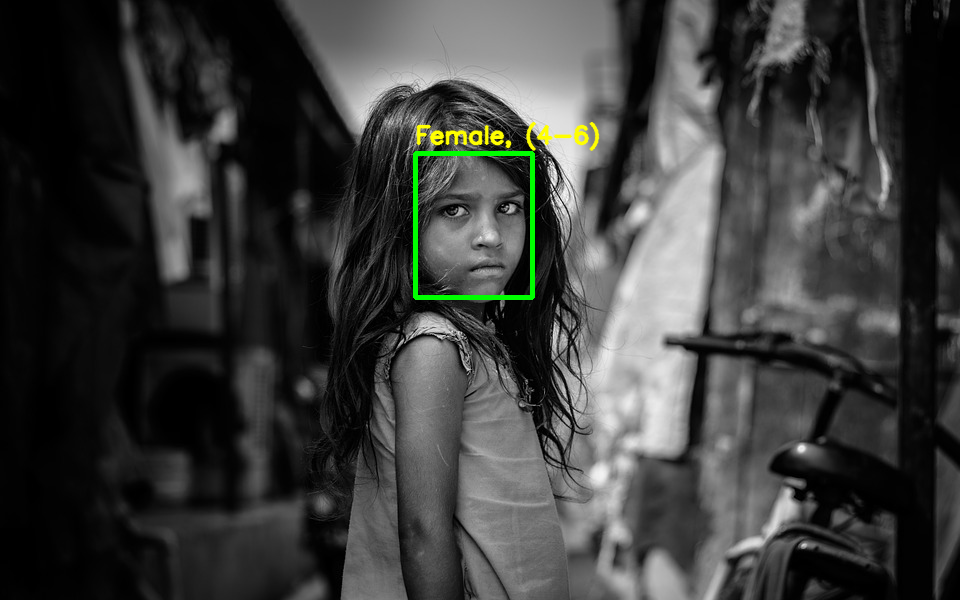

In [32]:
## Functions
def highlightFace(net, frame, conf_threshold=0.7):
    frameOpencvDnn=frame.copy()
    frameHeight=frameOpencvDnn.shape[0]
    frameWidth=frameOpencvDnn.shape[1]
    blob=cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections=net.forward()
    faceBoxes=[]
    for i in range(detections.shape[2]):
        confidence=detections[0,0,i,2]
        if confidence>conf_threshold:
            x1=int(detections[0,0,i,3]*frameWidth)
            y1=int(detections[0,0,i,4]*frameHeight)
            x2=int(detections[0,0,i,5]*frameWidth)
            y2=int(detections[0,0,i,6]*frameHeight)
            faceBoxes.append([x1,y1,x2,y2])
            cv2.rectangle(frameOpencvDnn, (x1,y1), (x2,y2), (0,255,0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn,faceBoxes
# --------------------------------------------------------------

## Main program 
MODEL_MEAN_VALUES=(78.4263377603, 87.7689143744, 114.895847746)
ageList=['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList=['Male','Female']

faceNet=cv2.dnn.readNet(faceModel,faceProto)
ageNet=cv2.dnn.readNet(ageModel,ageProto)
genderNet=cv2.dnn.readNet(genderModel,genderProto)

for name, data in images.items():
  video=cv2.VideoCapture(name)
  padding=20
  while cv2.waitKey(1)<0:
      hasFrame,frame=video.read()
      if not hasFrame:
          cv2.waitKey()
          break

      resultImg,faceBoxes=highlightFace(faceNet,frame)
      if not faceBoxes:
          print("No face detected")

      for faceBox in faceBoxes:
          face=frame[max(0,faceBox[1]-padding):
                    min(faceBox[3]+padding,frame.shape[0]-1),max(0,faceBox[0]-padding)
                    :min(faceBox[2]+padding, frame.shape[1]-1)]

          blob=cv2.dnn.blobFromImage(face, 1.0, (227,227), MODEL_MEAN_VALUES, swapRB=False)
          genderNet.setInput(blob)
          genderPreds=genderNet.forward()
          gender=genderList[genderPreds[0].argmax()]
          print(f'Gender: {gender}')

          ageNet.setInput(blob)
          agePreds=ageNet.forward()
          age=ageList[agePreds[0].argmax()]
          print(f'Age: {age[1:-1]} years')

          cv2.putText(resultImg, f'{gender}, {age}', (faceBox[0], faceBox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2, cv2.LINE_AA)
          imgshow(resultImg)
